In [1]:
import numpy as np
import pandas as pd
import os
import radvel
from radvel.plot import orbit_plots, mcmc_plots
from scipy import optimize
import ktwo19
import ktwo19.io
%pylab inline
%reload_ext autoreload
%autoreload 2 

gphot = pd.read_excel('data/data.xlsx',sheetname='phot-gp',squeeze=True,header=None,index_col=0)
data = ktwo19.io.load_table('rv')
%config InlineBackend.figure_format = 'retina'


def lagprod(t,r):
    n = len(t)
    prod = []
    lag = []
    for i in range(n):
        for j in range(n):
            if i==j:
                continue
            
            prod.append(r[i]*r[j])
            lag.append(t[i] - t[j])
    
    lag = np.abs(np.array(lag))
    prod = np.array(prod)
    return lag, prod


def bic2(post):
    n = len(post.likelihood.x)
    k = len(post.likelihood.get_vary_params())
    loglike = post.likelihood.logprob()
    bic = np.log(n) * k - 2 * loglike
    return bic

/Users/petigura/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _stats


ImportError: cannot import name select_autoescape

In [3]:
import radvel

/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ImportWarning: Not importing directory 'radvel': missing __init__.py
  """Entry point for launching an IPython kernel.
/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ImportWarning: Not importing directory '/Users/petigura/Research/K2-19_TTV+RV/radvel': missing __init__.py
  """Entry point for launching an IPython kernel.


ImportError: cannot import name posterior

## Circular orbits, no trend, white jitter

excluding obs: rj197.149
parameter                     value      vary
per1                        7.92075      False
k1                          7.42371       True
per2                         11.898      False
k2                         0.147633       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                              0      False
curv                              0      False
gamma                      -2.72731       True
jit                         8.73638       True

Priors
------



/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: OptimizeWarning: Unknown solver options: xatol
  # This is added back by InteractiveShellApp.init_path()
/Users/petigura/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/petigura/anaconda2/lib/python2.7/site-packages/radvel/utils.py:294: RuntimeWarning: invalid value encountered in divide
  bindat = sy / n


BIC = 385.0
AIC = 378.1
BIC' = 385.0


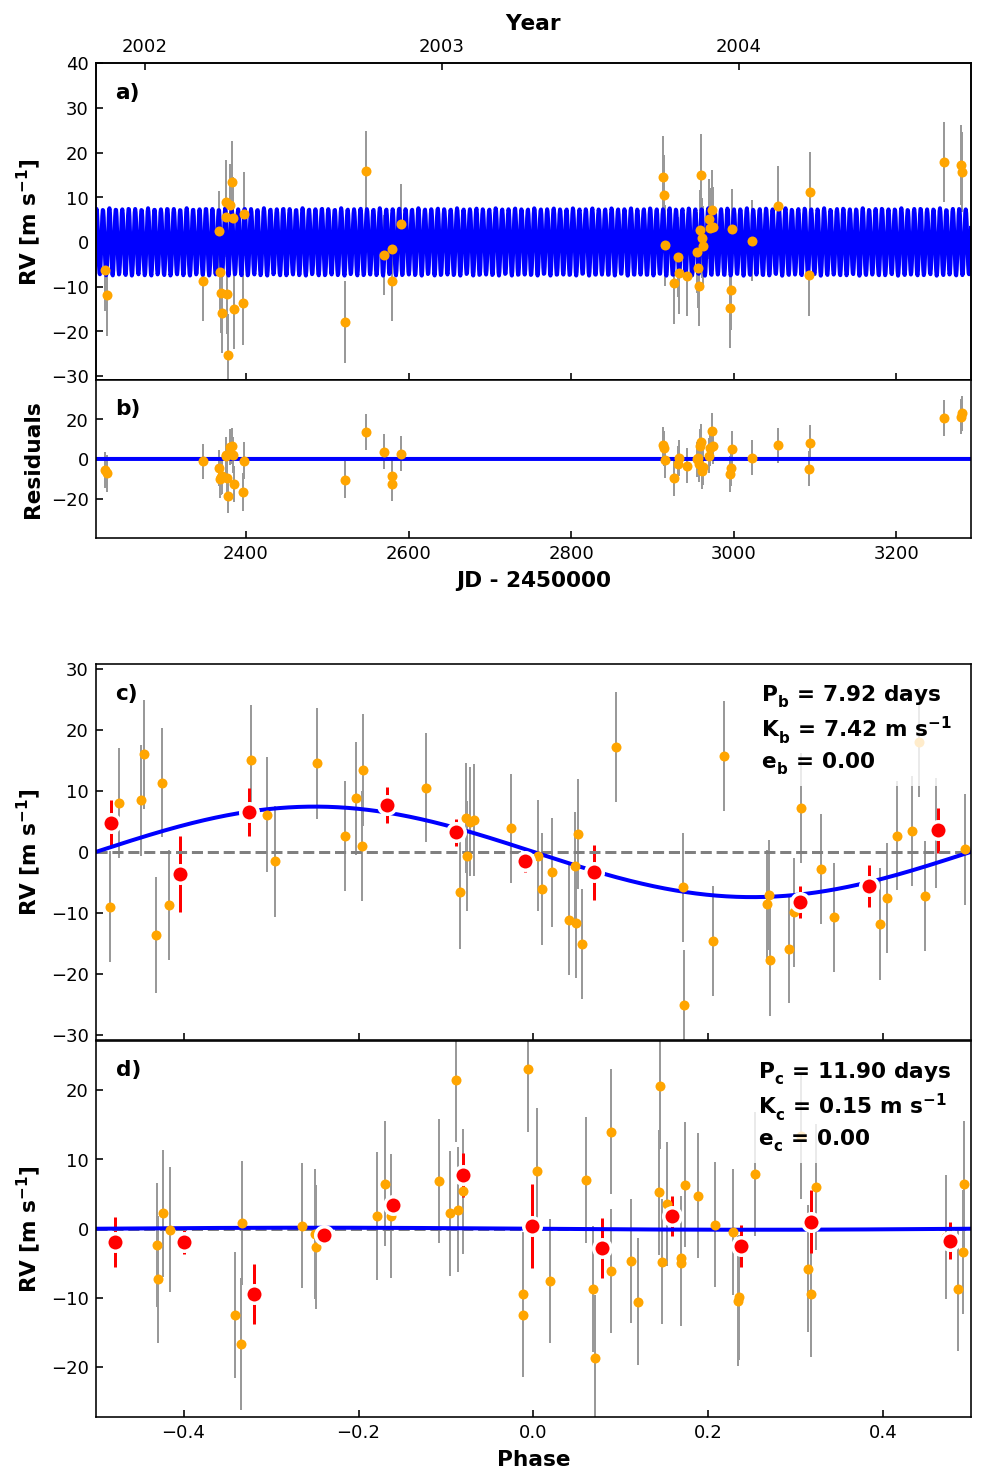

In [2]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)
like = radvel.likelihood.RVLikelihood(model, data.time, data.mnvel,data.errvel)
like.params['gamma'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])
post = radvel.posterior.Posterior(like)    

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print(post)
plotter = orbit_plots.MultipanelPlot(post)
plotter.plot_multipanel()
print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))

<Container object of 3 artists>

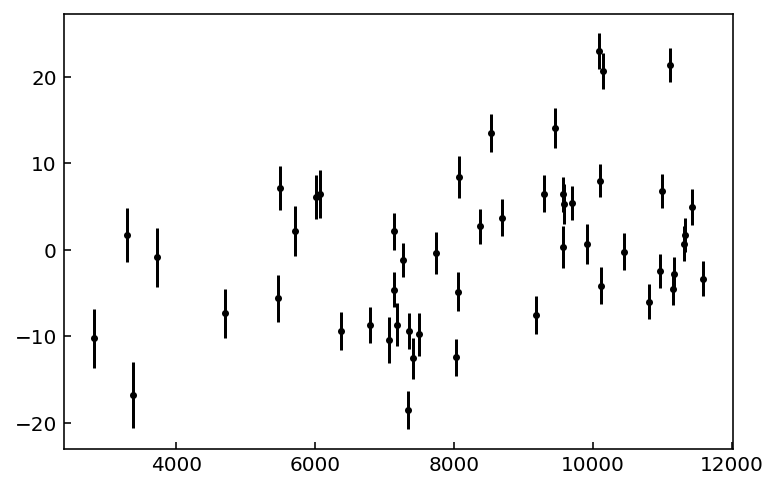

In [12]:
errorbar(data.cts,post.likelihood.residuals(),yerr=post.likelihood.yerr,fmt='.')

In [13]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 11842.58 steps/s; Mean acceptance rate = 64.1%; Min Tz = 498.9; Max G-R = 1.006      
Discarding burn-in now that the chains are marginally well-mixed

67500/150000 (45.0%) steps complete; Running 11797.68 steps/s; Mean acceptance rate = 59.1%; Min Tz = 2015.2; Max G-R = 1.001      
Chains are well-mixed after 67500 steps! MCMC completed in 5.9 seconds


                  mean   std
k1               7.386 2.034
k2               0.122 1.910
gamma           -2.755 1.390
jit              9.305 1.078
lnprobability -186.778 1.548


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Circular orbits, trend, white jitter

excluding obs: rj197.149
parameter                     value      vary
per1                        7.92075      False
k1                          9.01704       True
per2                         11.898      False
k2                         0.567047       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                      0.0164479       True
curv                              0      False
gamma                      -2.61151       True
jit                         7.14689       True

Priors
------



/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xatol
  if sys.path[0] == '':


BIC = 370.2
AIC = 361.9
BIC' = 370.2


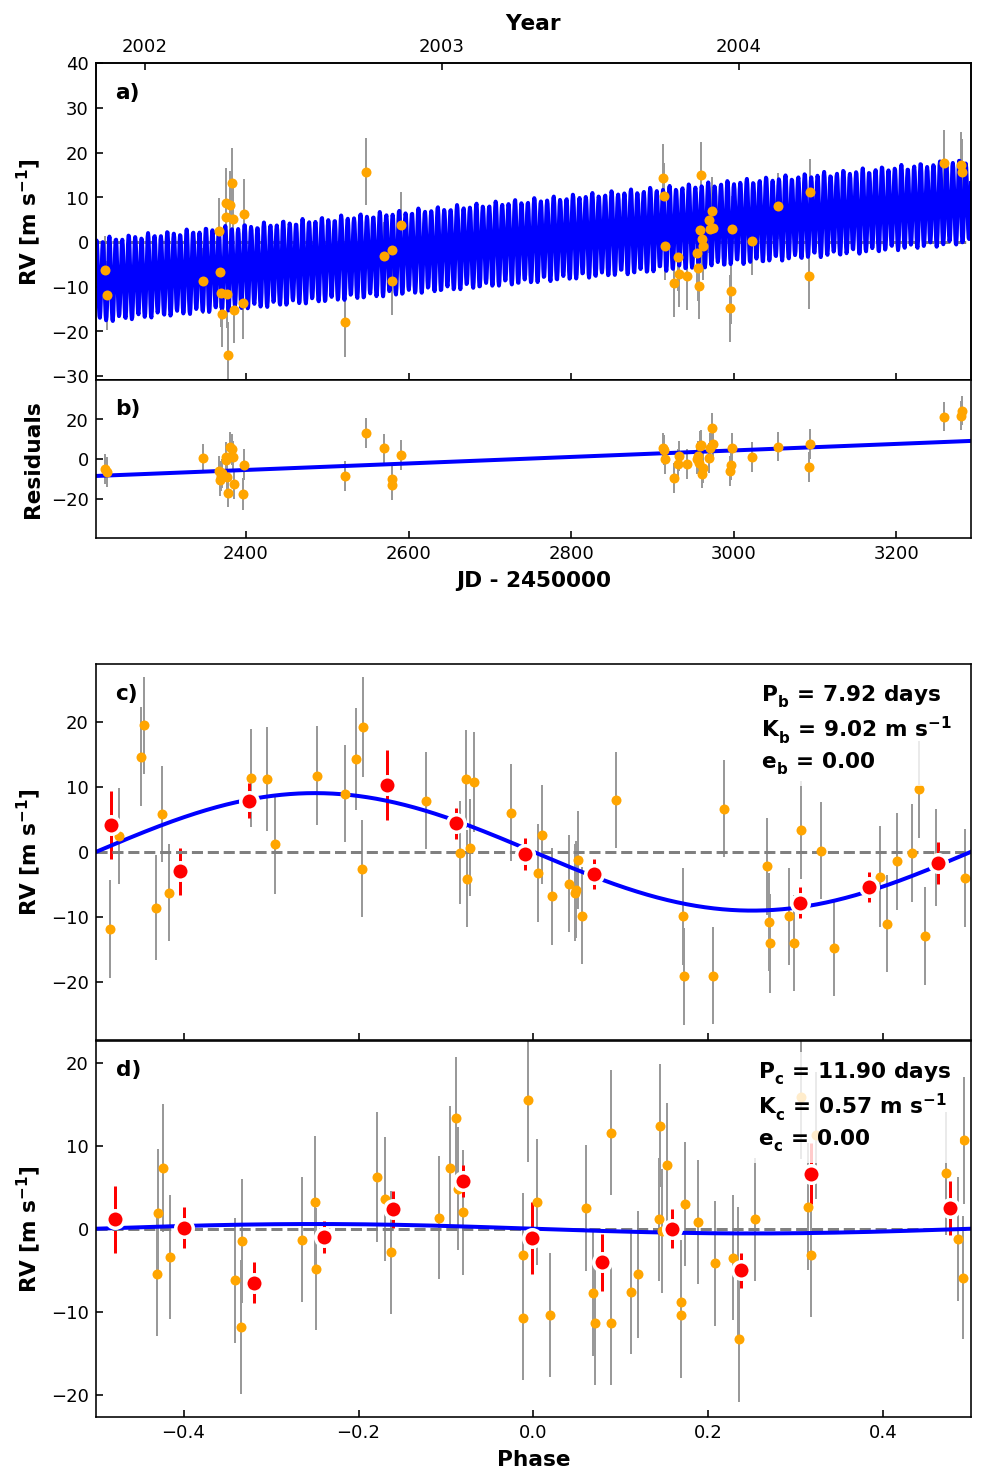

In [14]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)
like = radvel.likelihood.RVLikelihood(model, data.time, data.mnvel,data.errvel)
like.params['dvdt'].vary = True
like.params['gamma'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])
post = radvel.posterior.Posterior(like)    

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print(post)
plotter = orbit_plots.MultipanelPlot(post)
plotter.plot_multipanel()
print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))

<Container object of 3 artists>

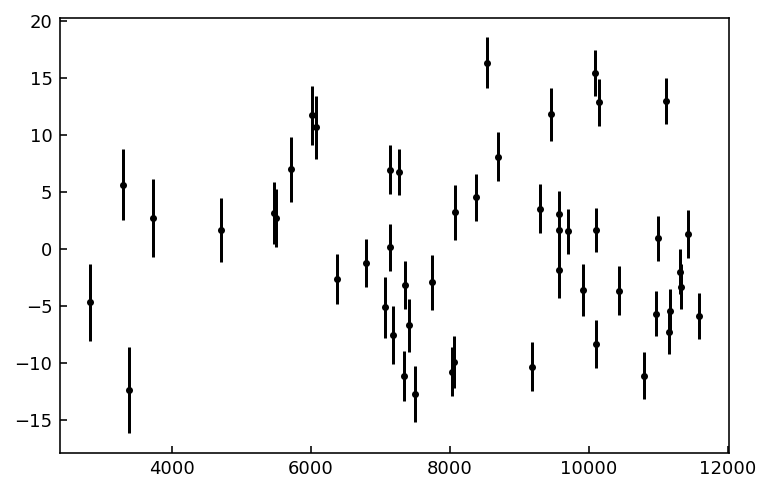

In [15]:
errorbar(data.cts,post.likelihood.residuals(),yerr=post.likelihood.yerr,fmt='.')

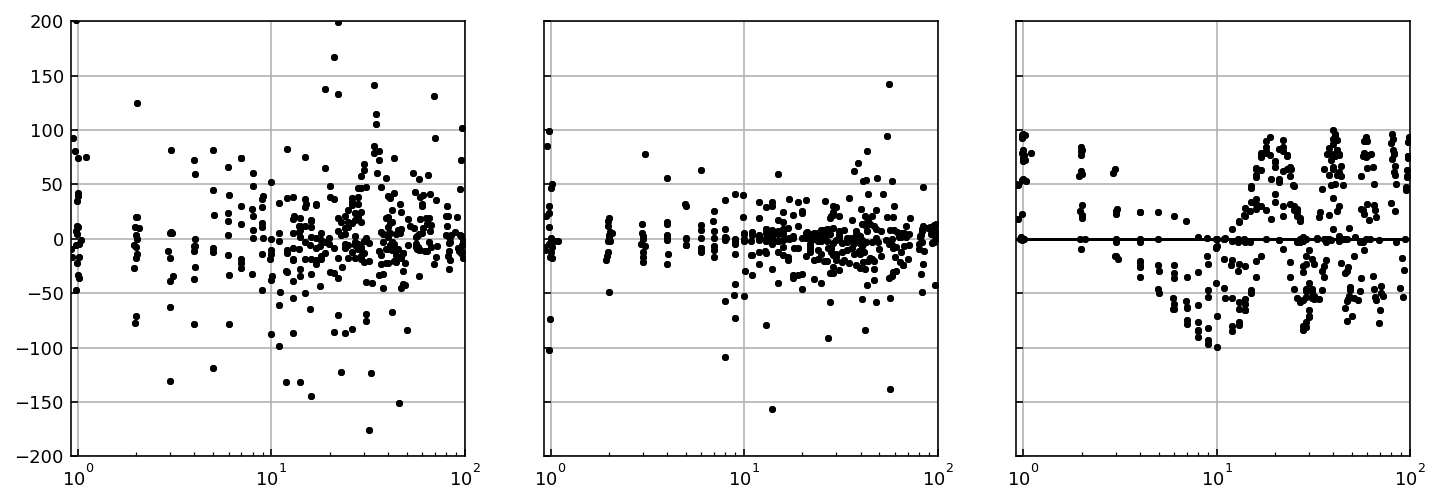

In [5]:

r = post.likelihood.residuals()
t = post.likelihood.x
lag,prod = lagprod(t,r)
  
r = np.random.randn(len(t))* 7
lag,prod_white = lagprod(t,r)


r = np.sin(2*pi*t / 20) * 10
lag,prod_sin = lagprod(t,r)


fig, axL = subplots(ncols=3,figsize=(12,4),sharex=True,sharey=True)
sca(axL[0])
semilogx()
grid()

plot(lag,prod,'.')
sca(axL[1])
plot(lag,prod_white,'.')
grid()


sca(axL[2])
plot(lag,prod_sin,'.')
grid()


xlim(0,100)
ylim(-200,200)
axhline(0)

test = pd.DataFrame(dict(lag=lag,prod=prod))
g = test.groupby(pd.cut(test.lag,bins=np.logspace(log10(1),log10(1000),1000)))
mn = g.mean()
#plot(mn.lag,mn['prod'],'o')


(1, 100)

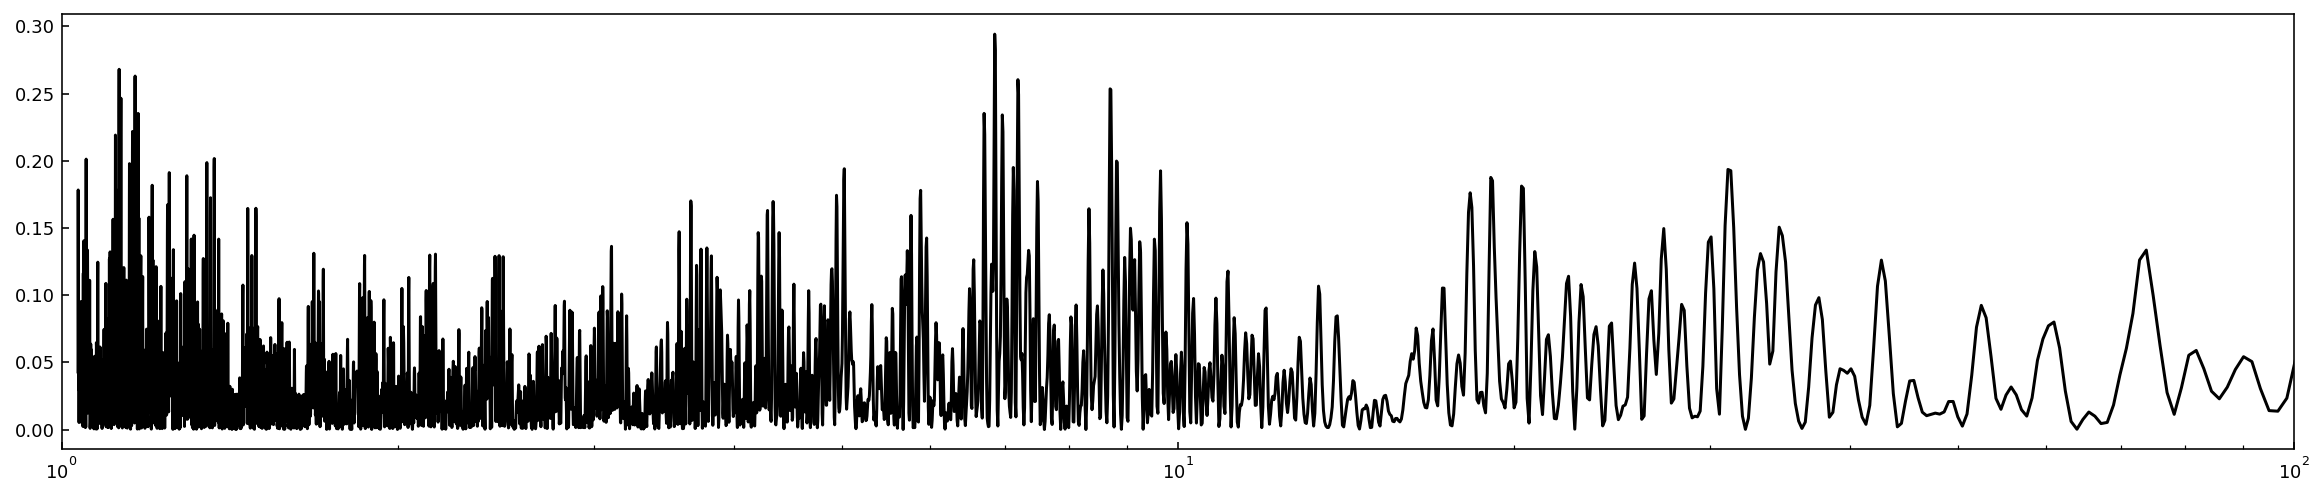

In [6]:
from astropy.stats import LombScargle
ls = LombScargle(post.likelihood.x - post.likelihood.x.mean(), post.likelihood.residuals())
frequency, power = ls.autopower(nyquist_factor=40)
figure(figsize=(20,4))
semilogx(1/frequency, power)
xlim(1,100)

In [7]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 8792.24 steps/s; Mean acceptance rate = 58.6%; Min Tz = 339.7; Max G-R = 1.009      
Discarding burn-in now that the chains are marginally well-mixed

60000/150000 (40.0%) steps complete; Running 8865.91 steps/s; Mean acceptance rate = 55.2%; Min Tz = 2722.5; Max G-R = 1.001      
Chains are well-mixed after 60000 steps! MCMC completed in 6.9 seconds


                  mean   std
k1               9.022 1.784
k2               0.599 1.590
dvdt             0.017 0.004
gamma           -2.666 1.153
jit              7.659 0.899
lnprobability -177.949 1.685


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Circular orbits, no trend, GP

excluding obs: rj197.149


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: OptimizeWarning: Unknown solver options: xatol


parameter                     value      vary
per1                        7.92075      False
k1                          11.8917       True
per2                         11.898      False
k2                         0.230019       True
tc1                         1980.38      False
secosw1                           0      False
sesinw1                           0      False
tc2                          1984.3      False
secosw2                           0      False
sesinw2                           0      False
dvdt                              0      False
curv                              0      False
gp_amp                      8.48889       True
gp_explength                33.9844      False
gp_per                      20.3878      False
gp_perlength                 0.4859      False
gamma_j                      -1.956       True
jit_j                       3.61865       True

Priors
------
Jeffrey's prior on gp_amp, min=0.1, max=30.0
Gaussian prior on gp_explength, mu=33.984398, si

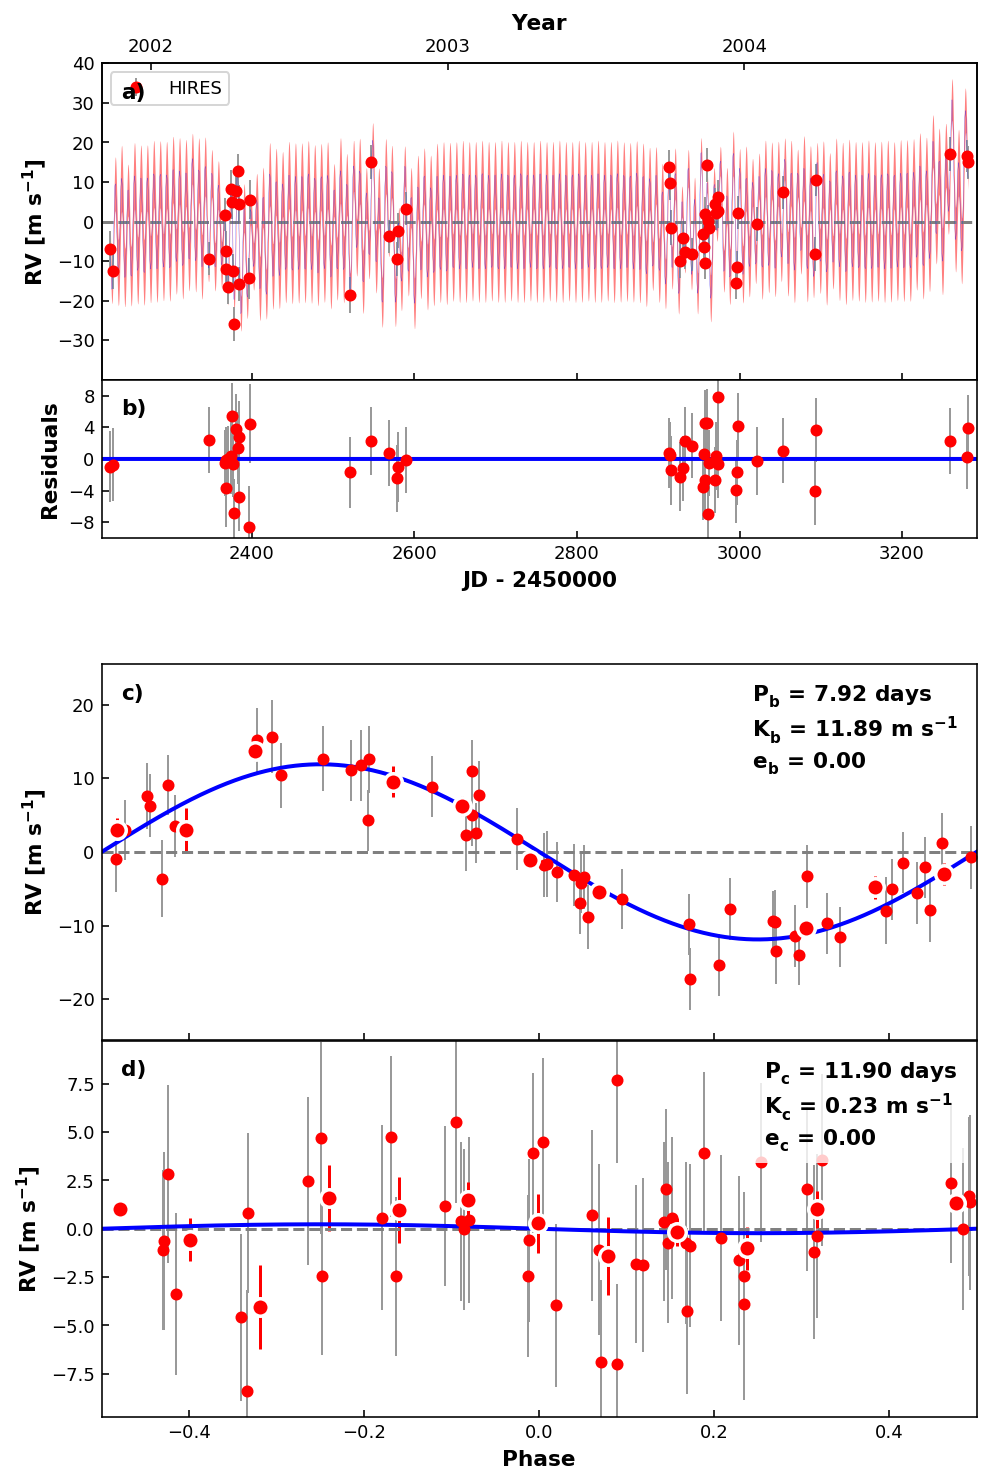

In [8]:
%run analysis/radvel/ktwo19_npl=2-default.py
model = radvel.model.RVModel(params,time_base=time_base)

# Add in GP parameters
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_explength'] = radvel.Parameter(value=gphot.eta2,vary=False)
params['gp_per'] = radvel.Parameter(value=gphot.eta3,vary=False)
params['gp_perlength'] = radvel.Parameter(value=gphot.eta4,vary=False)
like = radvel.likelihood.GPLikelihood(
    model, data.time, data.mnvel,data.errvel, hnames, suffix='_j',
    kernel_name="QuasiPer"
)

model = radvel.model.RVModel(params,time_base=2500)
like.params['gamma_j'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit_j'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])

post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.Jeffreys('gp_amp', 0.1, 30.)]
post.priors += [radvel.prior.Gaussian('gp_explength', gphot.eta2, gphot.eta2_err)]
post.priors += [radvel.prior.Gaussian('gp_per', gphot.eta3, gphot.eta3_err)]
post.priors += [radvel.prior.Gaussian('gp_perlength', gphot.eta4, gphot.eta4_err)]
post.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]

res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)


print(post)
plotter = orbit_plots.GPMultipanelPlot(post,subtract_orbit_model=False)
plotter.plot_multipanel()
axL = gcf().get_axes()
sca(axL[0])
ylim(-40,40)
print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post) )


In [9]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.1f')

7500/150000 (5.0%) steps complete; Running 4799.57 steps/s; Mean acceptance rate = 59.7%; Min Tz = 684.8; Max G-R = 1.004      
Discarding burn-in now that the chains are marginally well-mixed

112500/150000 (75.0%) steps complete; Running 4754.08 steps/s; Mean acceptance rate = 54.9%; Min Tz = 1515.1; Max G-R = 1.002      
Chains are well-mixed after 112500 steps! MCMC completed in 24.1 seconds


                mean  std
k1              11.9  1.7
k2               0.2  1.9
gp_amp           9.4  1.9
gamma_j         -1.9  2.7
jit_j            3.8  1.1
lnprobability -185.4  1.8


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## Circular orbits, trend, GP

In [1]:
%run analysis/radvel/ktwo19_npl=3-default.py
model = radvel.model.RVModel(params,time_base=time_base)

# Add in GP parameters
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_explength', # eta_2; GP non-periodic characteristic length
    'gp_per', # eta_3; GP variability period
    'gp_perlength', # eta_4; GP periodic characteristic length
]
params['gp_amp'] = radvel.Parameter(value=5,vary=True)
params['gp_explength'] = radvel.Parameter(value=gphot.eta2,vary=True)
params['gp_per'] = radvel.Parameter(value=gphot.eta3,vary=True)
params['gp_perlength'] = radvel.Parameter(value=gphot.eta4,vary=True)
like = radvel.likelihood.GPLikelihood(
    model, data.time, data.mnvel,data.errvel, hnames, suffix='_j',
    kernel_name="QuasiPer"
)

model = radvel.model.RVModel(params,time_base=2500)
like.params['gamma_j'] = radvel.Parameter(value=data.mnvel.mean())
like.params['jit_j'] = radvel.Parameter(value=1)
like = radvel.likelihood.CompositeLikelihood([like])

post = radvel.posterior.Posterior(like)    
post.priors += [radvel.prior.Jeffreys('gp_amp', 0.1, 30.)]
post.priors += [radvel.prior.Gaussian('gp_explength', gphot.eta2, gphot.eta2_err)]
post.priors += [radvel.prior.Gaussian('gp_per', gphot.eta3, gphot.eta3_err)]
post.priors += [radvel.prior.Gaussian('gp_perlength', gphot.eta4, gphot.eta4_err)]
post.priors += [radvel.prior.Jeffreys('jit_j', 0.01, 10.)]
post.params['dvdt'].vary=True
res = optimize.minimize(
    post.neglogprob_array, post.get_vary_params(), method='Powell',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)

print(post)


/Users/petigura/anaconda2/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _stats


ImportError: cannot import name select_autoescape

NameError: name 'radvel' is not defined

BIC = 397.8
AIC = 384.0
BIC' = 382.7


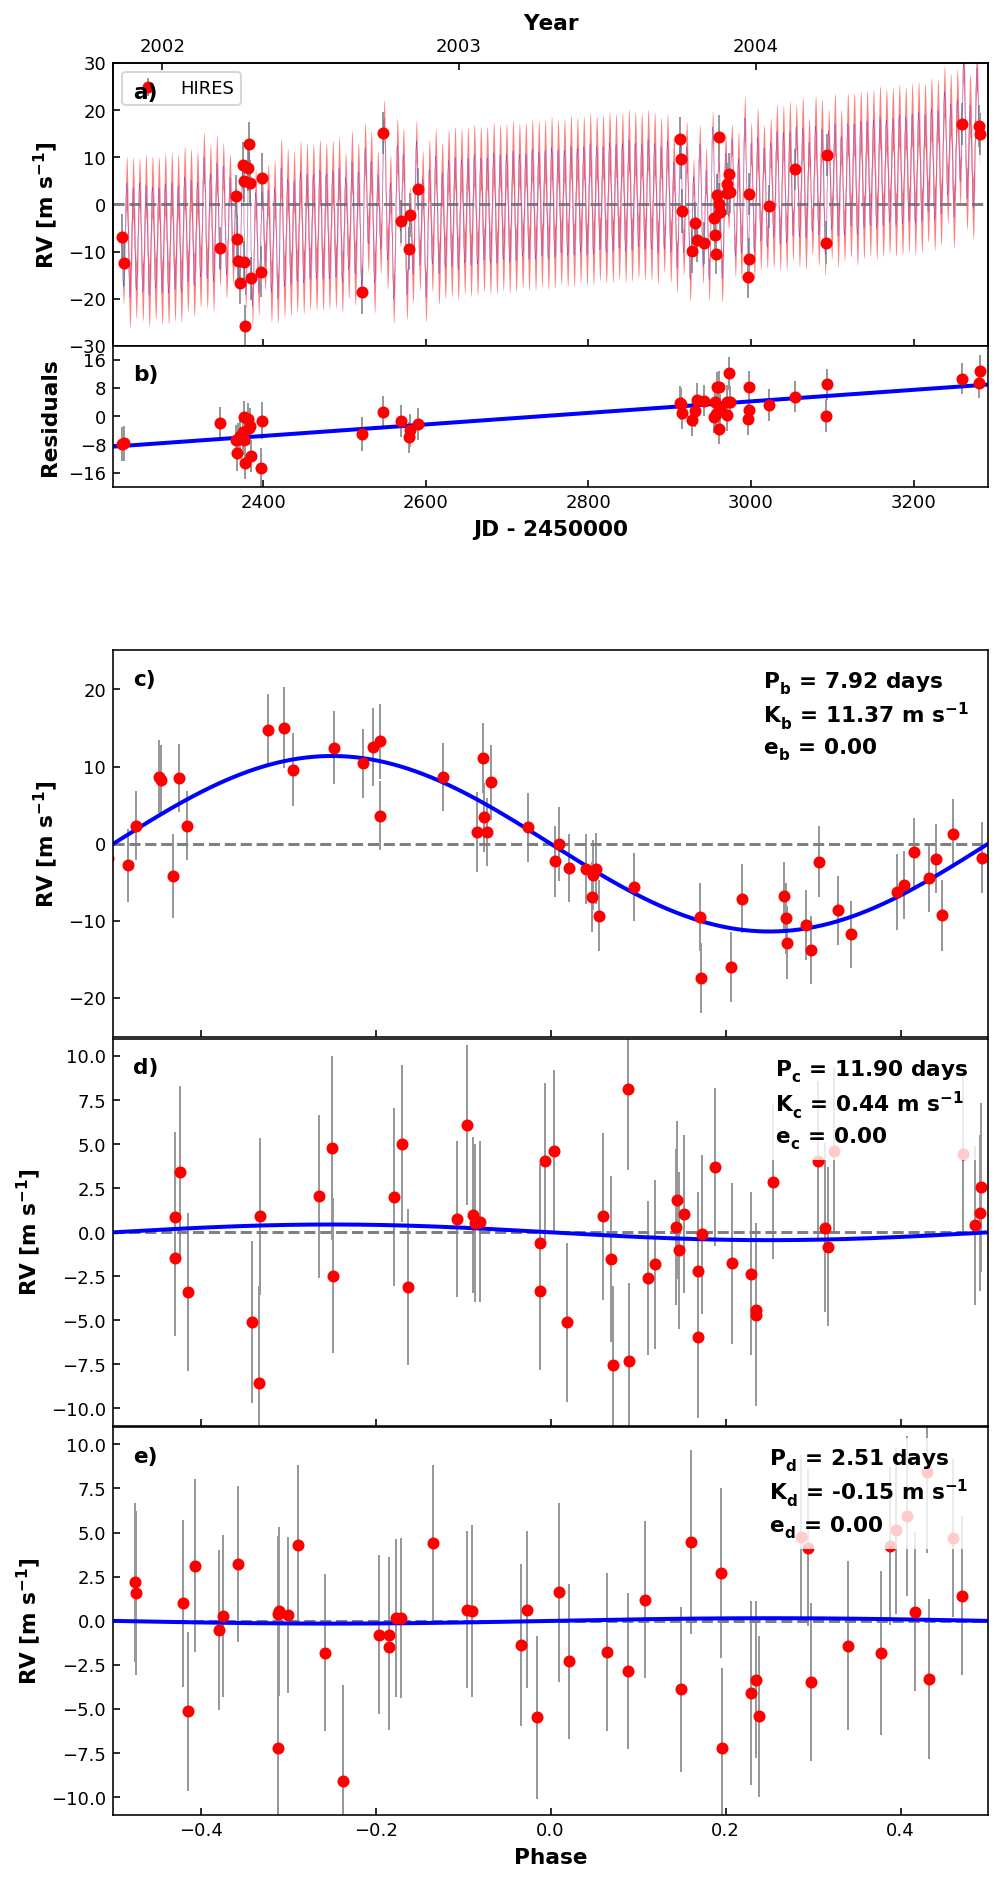

In [41]:

plotter = orbit_plots.GPMultipanelPlot(post,subtract_orbit_model=False,nobin=True)
plotter.plot_multipanel()
fig = gcf()
axL = fig.get_axes()

setp(axL[0:2],ylim=(-30,30))

#setp(axL[0:3],ylim=(-30,30),xlim=(2360,2400))
#setp(axL[0:3],ylim=(-20,20),xlim=(2500,2600))
#setp(axL[0:3],ylim=(-20,20),xlim=(2900,3000))


print "BIC = {:.1f}".format( post.bic())
print "AIC = {:.1f}".format( post.aic())
print "BIC' = {:.1f}".format( bic2(post))
fig.savefig('fig_rv.pdf') 

In [28]:
chains = radvel.mcmc(post,nrun=1000,ensembles=3)
print  chains.describe().ix[['mean','std']].T.to_string(float_format='%.3f')

7500/150000 (5.0%) steps complete; Running 4450.25 steps/s; Mean acceptance rate = 47.0%; Min Tz = 306.3; Max G-R = 1.010      
Discarding burn-in now that the chains are marginally well-mixed

90000/150000 (60.0%) steps complete; Running 4218.07 steps/s; Mean acceptance rate = 40.6%; Min Tz = 1241.6; Max G-R = 1.002      
Chains are well-mixed after 90000 steps! MCMC completed in 20.7 seconds


                  mean   std
k1              11.353 1.827
k2               0.542 1.529
k3              -0.172 0.954
dvdt             0.016 0.007
gp_amp           7.418 2.461
gp_explength    34.700 4.886
gp_per          20.330 0.321
gp_perlength     0.456 0.070
gamma_j         -1.999 2.114
jit_j            4.229 1.526
lnprobability -184.534 2.414


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [44]:
chains.to_hdf('data/keplerian_mcmc.hdf','chain')

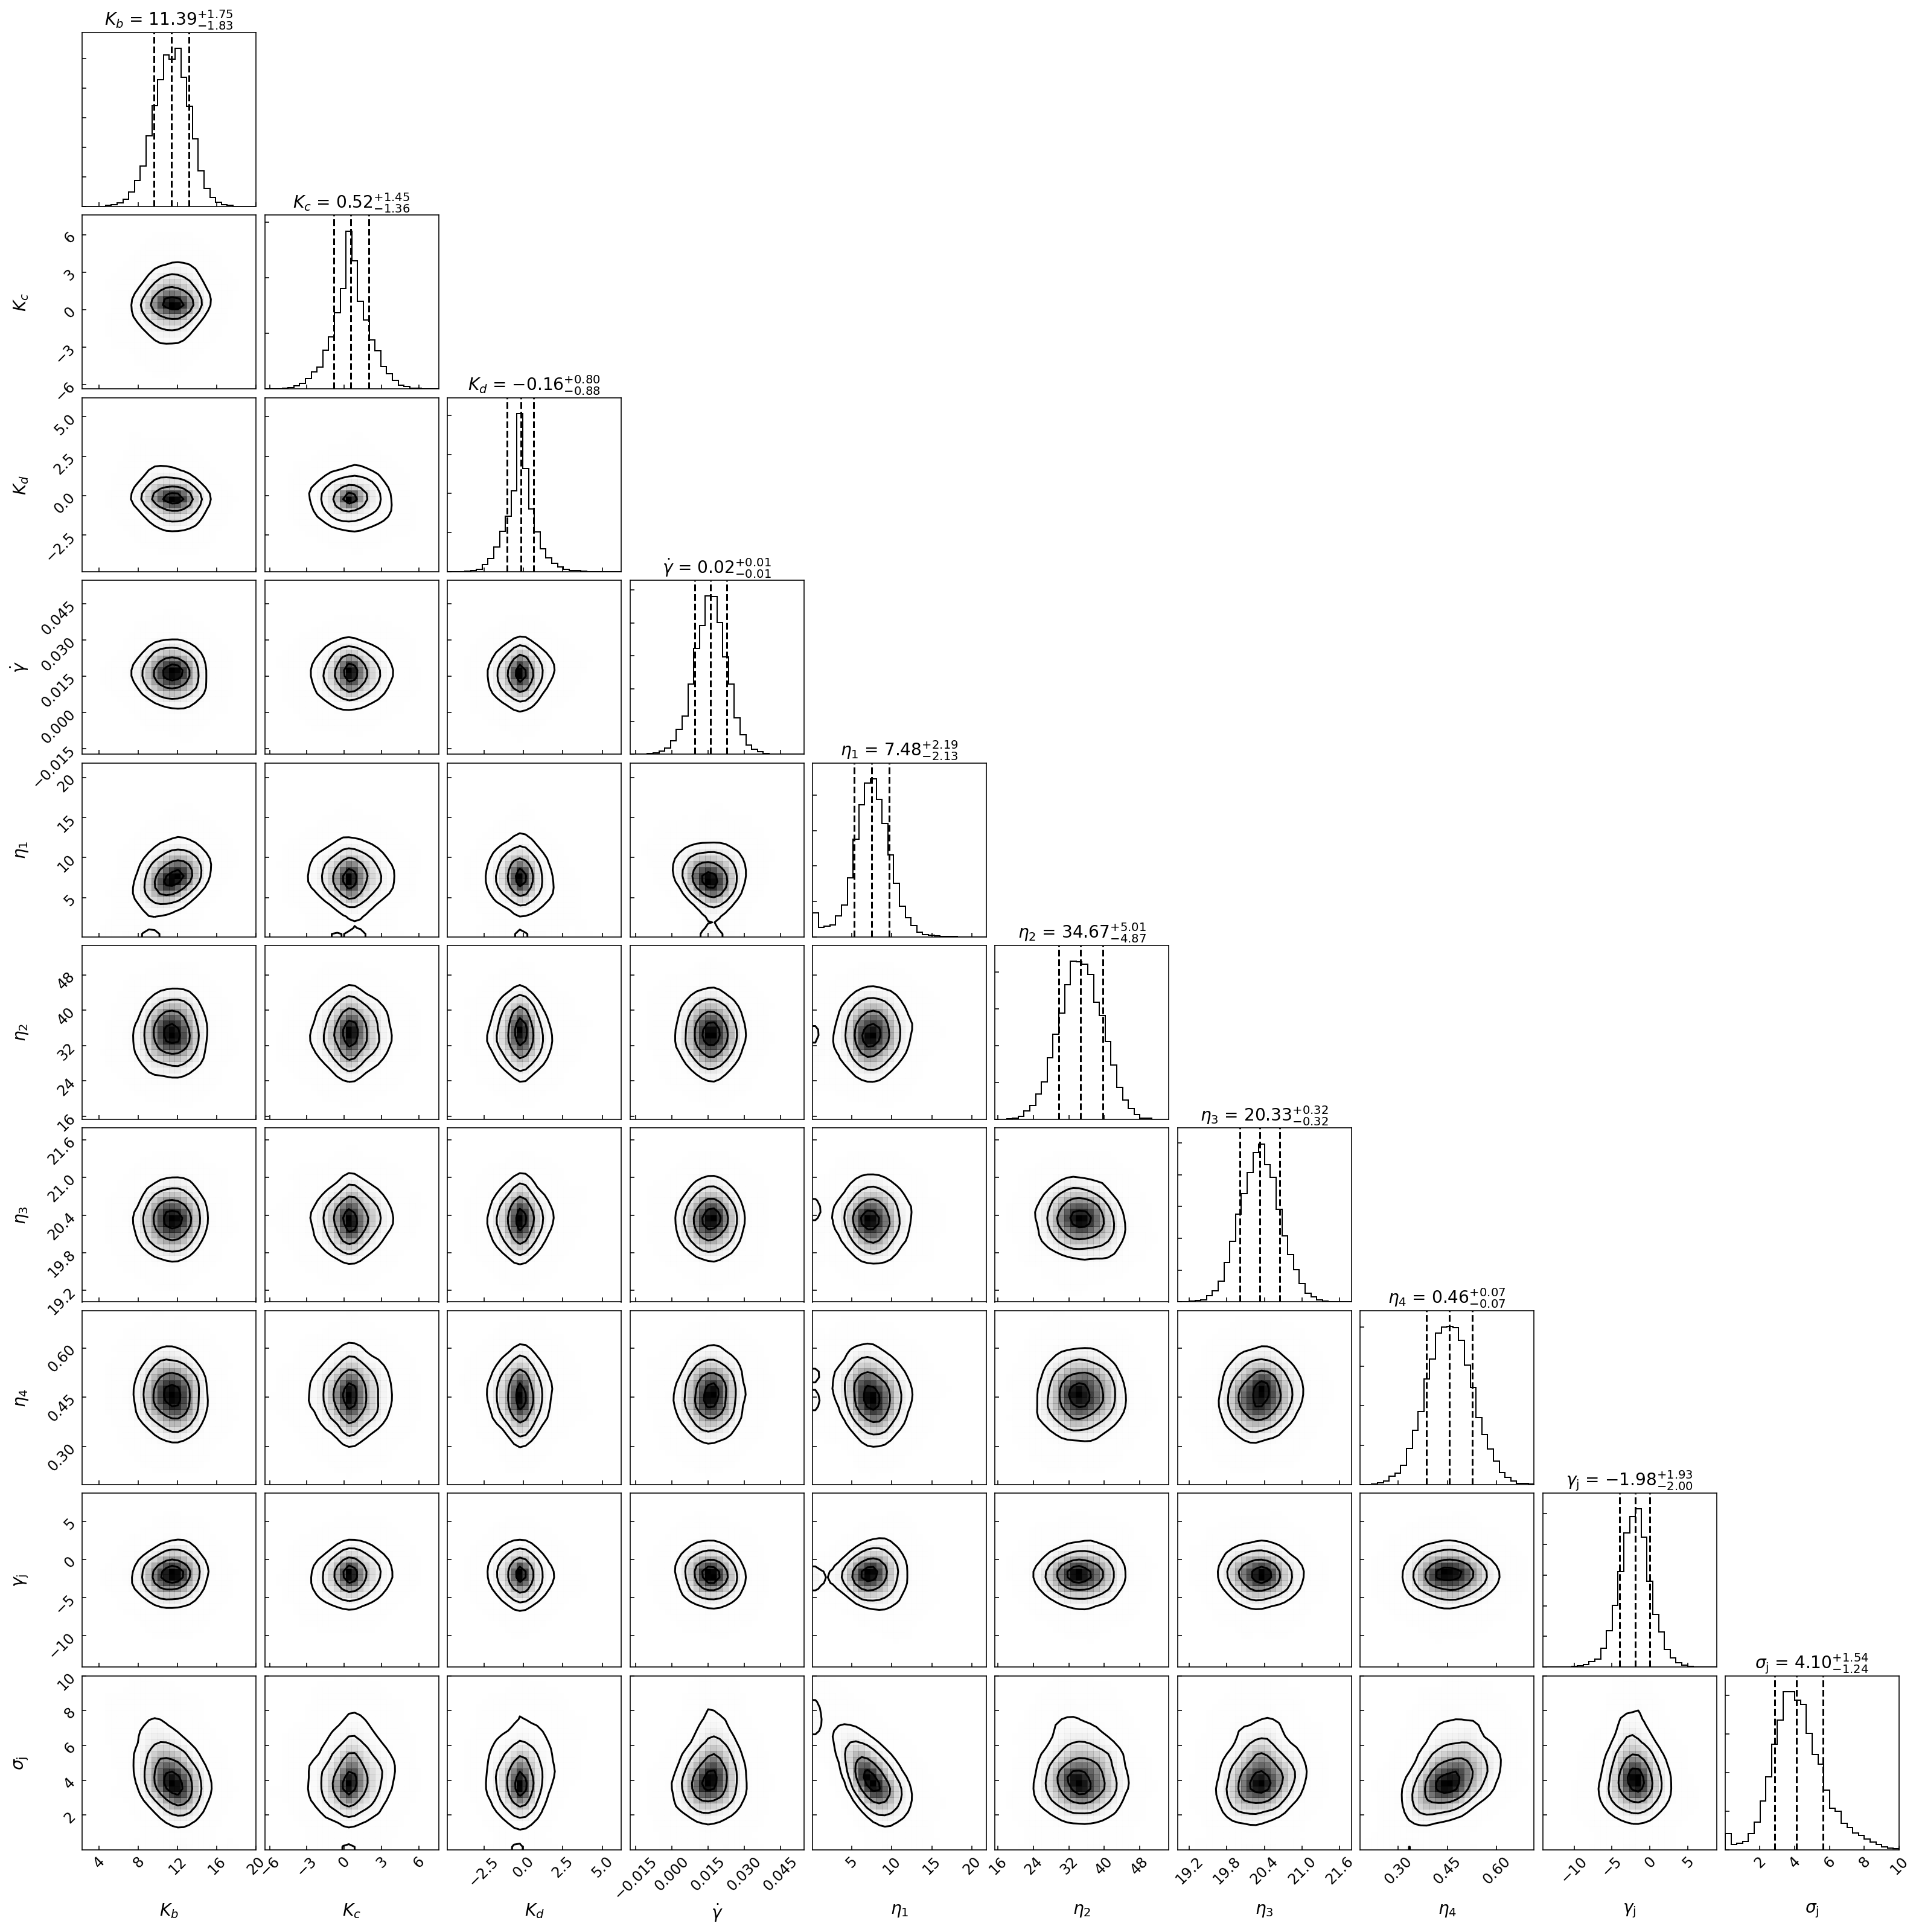

In [29]:
Corner = mcmc_plots.CornerPlot(post, chains) # posterior distributions
Corner.plot()

In [51]:
import ktwo19.io
reload(ktwo19.io)
import ktwo19.keplerian
reload(ktwo19.keplerian)

ktwo19.io.load_table('keplerian-samples',cache=1)

Cache not built for table: keplerian-samples
Building cache...
excluding obs: rj197.149
excluding obs: rj197.149
7500/150000 (5.0%) steps complete; Running 4478.03 steps/s; Mean acceptance rate = 47.1%; Min Tz = 633.1; Max G-R = 1.005      
Discarding burn-in now that the chains are marginally well-mixed

112500/150000 (75.0%) steps complete; Running 4221.27 steps/s; Mean acceptance rate = 40.9%; Min Tz = 1382.4; Max G-R = 1.002      
Chains are well-mixed after 112500 steps! MCMC completed in 26.9 seconds


writing table keplerian-samples to cache


/Users/petigura/anaconda2/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'keplerian-samples'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


,k1,k2,k3,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability
0,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.984604
1,9.588337,0.406802,-0.131867,0.013221,9.280659,28.824057,20.084855,0.520138,-2.546765,3.904446,-181.984604
2,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-181.786290
3,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.786290
4,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-181.786290
5,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.127742
6,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.127742
7,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-182.109680
8,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.109680
9,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.536025


In [66]:
import ktwo19.io
reload(ktwo19.io)

ktwo19.io.load_table('keplerian-samples-derived')

read table keplerian-samples from load_table_cache.hdf


,k1,k2,k3,dvdt,gp_amp,gp_explength,gp_per,gp_perlength,gamma_j,jit_j,lnprobability,smass,masse1,muppm1,masse2,muppm2,masse3,muppm3
0,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.984604,0.919029,30.236750,98.816395,0.667283,2.180739,-0.096210,-0.314424
1,9.588337,0.406802,-0.131867,0.013221,9.280659,28.824057,20.084855,0.520138,-2.546765,3.904446,-181.984604,0.894723,27.749713,93.152184,1.348767,4.527635,-0.260153,-0.873300
2,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-181.786290,0.870097,29.164300,100.671569,1.524108,5.261033,-0.038668,-0.133478
3,10.262649,0.197695,-0.047904,0.012807,7.035647,30.152901,20.188433,0.542452,-2.711607,5.207194,-181.786290,0.866746,29.078819,100.764645,0.641729,2.223735,-0.092526,-0.320623
4,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-181.786290,0.875825,26.104382,89.519820,0.937620,3.215384,-0.205165,-0.703574
5,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.127742,0.881648,29.421839,100.229993,1.537567,5.237957,-0.039010,-0.132893
6,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.127742,0.898144,32.729929,109.451575,1.537509,5.141556,-0.152935,-0.511426
7,9.149114,0.286850,-0.105485,0.010938,10.618099,28.353245,20.289219,0.514899,-2.368100,3.603835,-182.109680,0.817146,24.924984,91.613285,0.895259,3.290577,-0.195896,-0.720028
8,10.266369,0.468320,-0.019968,0.020806,6.726796,44.351072,20.469019,0.367552,-2.614139,3.805293,-182.109680,0.939925,30.704474,98.114180,1.604597,5.127386,-0.040710,-0.130088
9,11.280408,0.462550,-0.077323,0.014315,6.796076,30.195419,20.124455,0.540917,-2.050146,5.340412,-182.536025,0.921374,33.291863,108.523926,1.563906,5.097979,-0.155560,-0.507091


In [22]:
df = pd.read_csv('data/livingston-lc-fits/201505350.01-mcmc-samples.csv.gz')

In [23]:
import corner
df.describe().T['mean std'.split()]

,mean,std
t0,2.456813e+06,0.000269
p,7.919437e+00,0.000049
k,7.461775e-02,0.000760
a,1.946866e+01,0.645161
b,2.092326e-01,0.127967
q1,4.462596e-01,0.043355
q2,3.640621e-01,0.015512
c0,2.323264e-05,0.000013
ls,-9.011031e+00,0.065893


In [15]:
print "Livingston18 {}".format(0.000760 / 7.461775e-02)
print "Sinkoff15 {}".format(0.00060 / 0.07540)

Livingston18 0.0101852441276
Sinkoff15 0.0079575596817
